In [1]:
#import nltk
#nltk.download('stopwords')
#import re

In [2]:
#%%bash
#wget http://nlp.stanford.edu/data/glove.6B.zip
#unzip glove.6B.zip

In [3]:
from gensim.models.word2vec import Word2Vec
from sklearn.externals import joblib

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from string import maketrans 
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from tqdm import tqdm
%matplotlib inline

import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

In [5]:
np.random.seed(1234)

In [6]:
df_train = pd.read_csv('spam.csv', encoding='latin-1')

In [7]:
df_train = df_train.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df_train.columns = ['label', 'message']

In [8]:
array_label = df_train['label'].values
Y_full_train = np.where(array_label == 'spam', 1, 0)

In [9]:
df_train['length'] = df_train['message'].apply(len)
df_train.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


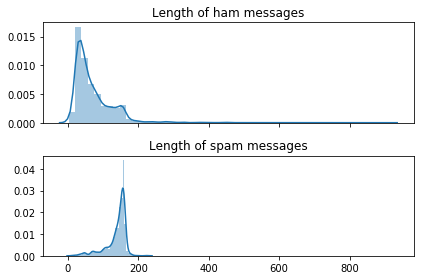

In [10]:
length_ham = df_train[df_train['label'] == 'ham'].length.values
length_spam = df_train[df_train['label'] == 'spam'].length.values
fig, axes = plt.subplots(nrows = 2, sharex= True)
sns.distplot(length_ham, ax= axes[0]).set_title('Length of ham messages')
sns.distplot(length_spam, ax = axes[1]).set_title('Length of spam messages')
plt.tight_layout()
plt.show()

In [11]:
df_messages = df_train['message'].copy()

In [12]:
def text_process(s):
    s = str(s)
    s = s.translate(None, string.punctuation)
    s = re.sub(' +',' ',s)
    s = s.decode('utf-8', 'ignore')
    s = s.lower()
    s = [word for word in s.split() if word.lower() not in stopwords.words('english')]
    return " ".join(s)

In [13]:
df_messages = df_messages.apply(lambda x: text_process(x))

In [14]:
ham_words =  ''
spam_words = ''

for idx in range(len(df_messages)):
    if array_label[idx] == 'ham':
        ham_words += '' + str(df_messages.iloc[idx])
    else:
        spam_words += '' + str(df_messages.iloc[idx])

In [15]:
from wordcloud import WordCloud
spam_wordcloud = WordCloud(width=600, height=400).generate(spam_words)
ham_wordcloud = WordCloud(width=600, height=400).generate(ham_words)

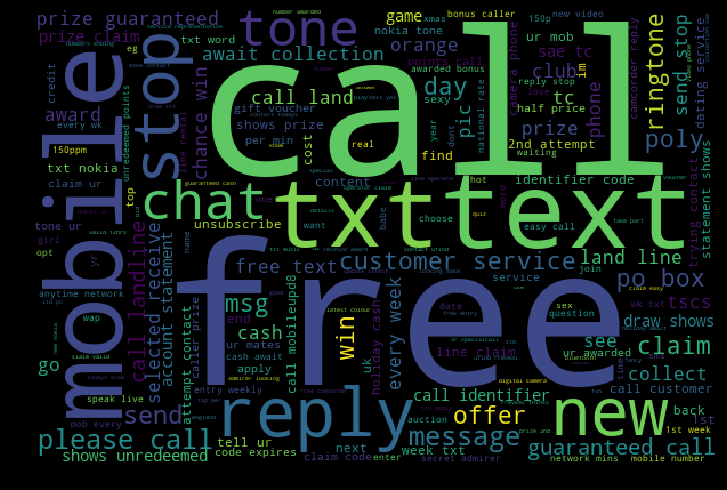

In [16]:
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

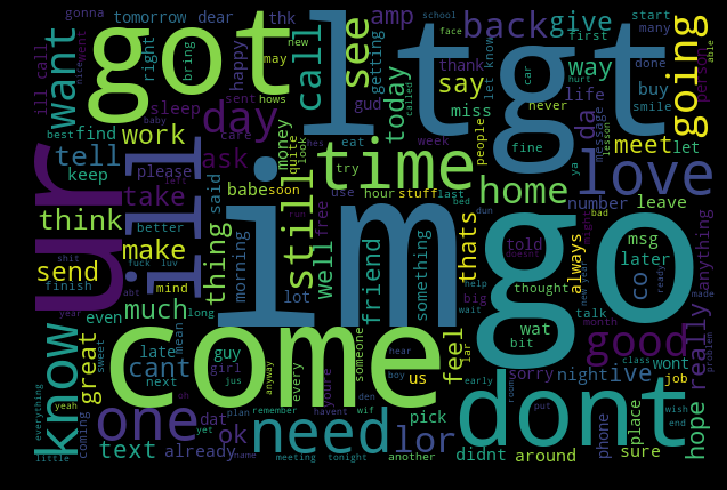

In [17]:
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [18]:
n_obs = len(df_messages)

## Another Approach

- NB - Length
- SVC - Length

- NB - Count Vectorizer 
- SVC - Count Vectorizer
- NB - Count Vectorizer + Logistic 
- SVC - Count Vectorizer+ Logistic

- NB - Tfidf
- SVC - Tfidf
- NB - Tfidf+ Logistic
- SVC - Tfidf+ Logistic

- NB - W2V
- SVC - W2V
- NB - W2V + Logistic
- SVC - W2V + Logistic

- NB - Glove
- SVC - Glove
- NB - Glove + Logistic
- SVC - Glove + Logistic

In [19]:
train_index, test_index = train_test_split(np.arange(n_obs), test_size = 0.2)

In [20]:
kfold = KFold(n_splits = 5, shuffle = True, random_state=1234)

In [21]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

## Length Model

In [93]:
X_length = df_train['length'].values.reshape(-1, 1)

In [94]:
print (X_length.shape)
print (Y_full_train.shape)

(5572, 1)
(5572,)


In [95]:
logistic_length_model = LogisticRegressionCV()
logistic_length_score = cross_val_score(logistic_length_model, X_length, Y_full_train, scoring = 'accuracy', cv = kfold.split(X_length), n_jobs=-1).mean()
print logistic_length_score

0.8458363590986305


## Simple Count

In [96]:
count_vectorizer = CountVectorizer()
X_full_train = count_vectorizer.fit_transform(df_messages)

In [97]:
print (X_full_train.shape)
print (Y_full_train.shape)

(5572, 9376)
(5572,)


In [98]:
svc_count_model = LinearSVC()
svc_count_score = cross_val_score(svc_count_model, X_full_train, Y_full_train, scoring = 'accuracy', cv = kfold.split(X_full_train), n_jobs=-1).mean()
print svc_count_score

0.9827718962088705


In [99]:
nb_count_model = MultinomialNB()
nb_count_score = cross_val_score(nb_count_model, X_full_train, Y_full_train, scoring = 'accuracy', cv = kfold.split(X_full_train), n_jobs=-1).mean()
print nb_count_score

0.9737982948370112


In [100]:
result = []
ratio = 0.5
for train_index, test_index in kfold.split(X_full_train):
    X_length_train, X_length_test = X_length[train_index], X_length[test_index]
    X_train, Y_train = X_full_train[train_index], Y_full_train[train_index]
    X_test, Y_test = X_full_train[test_index], Y_full_train[test_index]
    nb_prob = MultinomialNB().fit(X_train, Y_train).predict_proba(X_test)[:, 0]
    lg_prob = LogisticRegressionCV().fit(X_length_train, Y_train).predict_proba(X_length_test)[:, 0]
    total_prob = ratio * nb_prob + (1 - ratio)* lg_prob
    Y_pred = np.where(total_prob >= 0.5, 0, 1)
    result.append(accuracy_score(Y_test, Y_pred))
ensemble_count_score = np.mean(result)
print ensemble_count_score

0.9840276626063715



## TF-IDF

In [101]:
tfidf_vectorizer = TfidfVectorizer("english")
X_full_train = tfidf_vectorizer.fit_transform(df_messages)

In [102]:
print (X_full_train.shape)
print (Y_full_train.shape)

(5572, 9376)
(5572,)


In [103]:
svc_tfidf_model = LinearSVC()
svc_tfidf_score = cross_val_score(svc_tfidf_model, X_full_train, Y_full_train, scoring = 'accuracy', cv = kfold.split(X_full_train), n_jobs=-1).mean()
print svc_tfidf_score

0.9784640651794124


In [104]:
nb_tfidf_model = MultinomialNB()
nb_tfidf_score = cross_val_score(nb_tfidf_model, X_full_train, Y_full_train, scoring = 'accuracy', cv = kfold.split(X_full_train), n_jobs=-1).mean()
print nb_tfidf_score 

0.96392799349494


In [105]:
result = []
ratio = 0.9
for train_index, test_index in kfold.split(X_full_train):
    X_length_train, X_length_test = X_length[train_index], X_length[test_index]
    X_train, Y_train = X_full_train[train_index], Y_full_train[train_index]
    X_test, Y_test = X_full_train[test_index], Y_full_train[test_index]
    nb_prob = MultinomialNB().fit(X_train, Y_train).predict_proba(X_test)[:, 0]
    lg_prob = LogisticRegressionCV().fit(X_length_train, Y_train).predict_proba(X_length_test)[:, 0]
    total_prob = ratio * nb_prob + (1 - ratio)* lg_prob
    Y_pred = np.where(total_prob >= 0.5, 0, 1)
    result.append(accuracy_score(Y_test, Y_pred))
ensemble_tfidf_score = np.mean(result)
print ensemble_tfidf_score

0.96213282237483


# Word2Vec

In [106]:
def w2v_to_features(w2v, list_tokens):
    w2v_keys = w2v.keys()
    n_dims = len(w2v[w2v.keys()[0]])
    result = np.zeros((len(list_tokens), n_dims))
    for idx in tqdm(range(len(list_tokens))):
        array_features = np.array([w2v[x] for x in list_tokens[idx] if x in w2v_keys])
        if len(array_features) == 0:
            continue
        else:
            result[idx] = array_features.mean(axis = 0)
    return result.astype('float64')

In [107]:
list_tokens = []
for idx in range(len(df_messages)):
    list_tokens.append([str(x) for x in df_messages.iloc[idx].split(' ')])

In [108]:
model = Word2Vec(list_tokens, size=100, window=5, min_count=10, workers=8)
word2vec = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

In [109]:
X_full_train = w2v_to_features(word2vec, list_tokens)

In [110]:
print (X_full_train.shape)
print (Y_full_train.shape)

(5572, 100)
(5572,)


In [111]:
svc_w2v_model = LinearSVC()
svc_w2v_score = cross_val_score(svc_w2v_model, X_full_train, Y_full_train, scoring = 'accuracy', cv = kfold.split(X_full_train), n_jobs=-1).mean()
print svc_w2v_score

0.8706043748138249


In [112]:
rf_w2v_model = RandomForestClassifier(n_estimators= 100, n_jobs = -1, random_state = 1234)
rf_w2v_score = cross_val_score(rf_w2v_model, X_full_train, Y_full_train, scoring = 'accuracy', cv = kfold.split(X_full_train), n_jobs=-1).mean()
print rf_w2v_score

0.9630292003123717


In [113]:
gb_w2v_model = GradientBoostingClassifier(n_estimators= 100)
gb_w2v_score = cross_val_score(gb_w2v_model, X_full_train, Y_full_train, scoring = 'accuracy', cv = kfold.split(X_full_train), n_jobs=-1).mean()
print gb_w2v_score

0.9547751809421066


In [114]:
result = []
ratio = 0.9
for train_index, test_index in kfold.split(X_full_train):
    X_length_train, X_length_test = X_length[train_index], X_length[test_index]
    X_train, Y_train = X_full_train[train_index], Y_full_train[train_index]
    X_test, Y_test = X_full_train[test_index], Y_full_train[test_index]
    nb_prob = RandomForestClassifier(n_estimators= 100, n_jobs = -1, random_state = 1234).fit(X_train, Y_train).predict_proba(X_test)[:, 0]
    lg_prob = LogisticRegressionCV().fit(X_length_train, Y_train).predict_proba(X_length_test)[:, 0]
    total_prob = ratio * nb_prob + (1 - ratio)* lg_prob
    Y_pred = np.where(total_prob >= 0.5, 0, 1)
    result.append(accuracy_score(Y_test, Y_pred))
ensemble_w2v_score = np.mean(result)
print ensemble_w2v_score

0.961952645095845


## Glove

In [83]:
with open('glove.6B.50d.txt', "rb") as lines:
    glove_word2vec = {line.split()[0]: np.array(map(float, line.split()[1:]))
               for line in lines}

In [ ]:
X_full_train = w2v_to_features(glove_word2vec, list_tokens)

In [ ]:
joblib.dump(X_full_train, "X_full_train.pkl")

In [115]:
X_full_train = joblib.load('X_full_train_GLOVE.pkl')

In [116]:
svc_glove_model = LinearSVC()
svc_glove_score = cross_val_score(svc_glove_model, X_full_train, Y_full_train, scoring = 'accuracy', cv = kfold.split(X_full_train), n_jobs=-1).mean()
print svc_glove_score

0.9256999782627947


In [117]:
rf_glove_model = RandomForestClassifier(n_estimators= 100, n_jobs = -1,random_state = 1234)
rf_glove_score = cross_val_score(rf_glove_model, X_full_train, Y_full_train, scoring = 'accuracy', cv = kfold.split(X_full_train), n_jobs=-1).mean()
print rf_glove_score

0.9617745610292163


In [118]:
gb_glove_model = GradientBoostingClassifier(n_estimators= 100)
gb_glove_score = cross_val_score(gb_glove_model, X_full_train, Y_full_train, scoring = 'accuracy', cv = kfold.split(X_full_train), n_jobs=-1).mean()
print gb_glove_score

0.959979067876436


In [119]:
result = []
ratio = 0.9
for train_index, test_index in kfold.split(X_full_train):
    X_length_train, X_length_test = X_length[train_index], X_length[test_index]
    X_train, Y_train = X_full_train[train_index], Y_full_train[train_index]
    X_test, Y_test = X_full_train[test_index], Y_full_train[test_index]
    nb_prob = RandomForestClassifier(n_estimators= 100, n_jobs = -1, random_state = 1234).fit(X_train, Y_train).predict_proba(X_test)[:, 0]
    lg_prob = LogisticRegressionCV().fit(X_length_train, Y_train).predict_proba(X_length_test)[:, 0]
    total_prob = ratio * nb_prob + (1 - ratio)* lg_prob
    Y_pred = np.where(total_prob >= 0.5, 0, 1)
    result.append(accuracy_score(Y_test, Y_pred))
ensemble_glove_score = np.mean(result)
print ensemble_glove_score

0.9594415953498483


In [126]:
result = {
    'label' : ['logistic_length_score', 'nb_count_score', 'svc_count_score', 'ensemble_count_score',
              'nb_tfidf_score', 'svc_tfidf_score', 'ensemble_tfidf_score', 'svc_w2v_score', 
              'rf_w2v_score', 'gb_w2v_score', 'ensemble_w2v_score', 'svc_glove_score', 'rf_glove_score',
              'gb_glove_score', 'ensemble_glove_score'],
    'score' : [logistic_length_score, nb_count_score, svc_count_score, ensemble_count_score,
          nb_tfidf_score, svc_tfidf_score, ensemble_tfidf_score, svc_w2v_score, 
          rf_w2v_score, gb_w2v_score, ensemble_w2v_score, svc_glove_score, rf_glove_score,
          gb_glove_score, ensemble_glove_score]
}
df_result = pd.DataFrame(result)
display(df_result)

,label,score
0,logistic_length_score,0.845836
1,nb_count_score,0.973798
2,svc_count_score,0.982772
3,ensemble_count_score,0.984028
4,nb_tfidf_score,0.963928
5,svc_tfidf_score,0.978464
6,ensemble_tfidf_score,0.962133
7,svc_w2v_score,0.870604
8,rf_w2v_score,0.963029
9,gb_w2v_score,0.954775


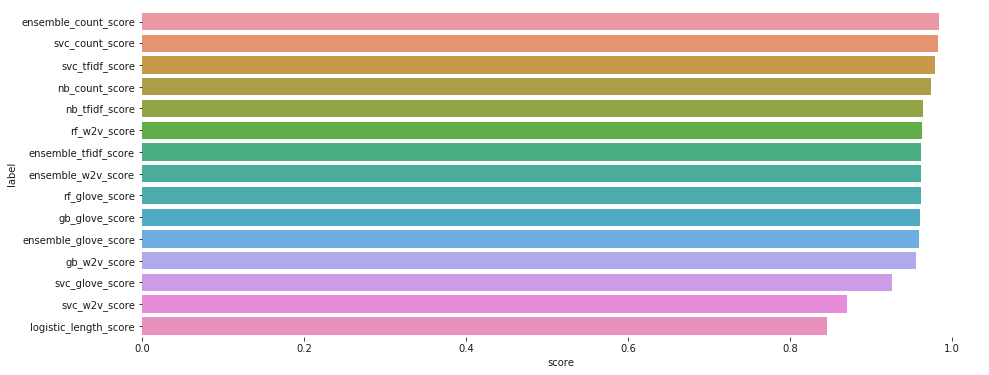

In [137]:
import seaborn as sns
df_result = df_result.sort_values('score', ascending=False)
f, ax = plt.subplots(figsize=(15, 6))
sns.set_color_codes("pastel")
ax = sns.barplot(x='score', y='label', data=df_result, orient='h')
sns.despine(left=True, bottom=True)